In [1]:
import numpy as np
from os import listdir
from tools.tool import cal_SNR,unpack,find_file,std_dev,cal_Tmk
from tools.tool import gmm_defined_analytic,gmm_predict,change_label
from tools.tool import gmm_analytic,confidence_ellipse_gmm
import scipy
import pandas as pd
from os import makedirs,listdir,remove
from os.path import exists
import matplotlib.pyplot as plt
import pickle
import time
from sympy import Matrix
from qutip import Bloch
from tools.Load_PYQUM import Load_pyqum
def find_csv_filenames( path_to_dir, suffix=".csv" ):
    filenames = listdir(path_to_dir)
    return [ filename for filename in filenames if filename.endswith( suffix ) ]

./data/Tomography/prepare
Comment : 
C1 ge ONESHOT 500+3000
JPA on 12.99/0
ROimRF-9dB
ROoutRF -20
Update: T6=14.816mK, REF#7604,7603,7601,7602,7600,7599,7594

	Data Checked!

Start load data....
R-JSON :
	 ROSTART  :  410000
	 ROdelay  :  280
	 ROL  :  0.06
	 ROW  :  8000
	 ROF  :  6.3483
	 XYL  :  0 0.078
	 XYW  :  40
	 XYF  :  4.558
	 XYD  :  0
	 ROSTART,ROdelay,XYW>ROSTART-ROdelay-XYW  :  0
	 ZW  :  500000
	 Z1  :  0.371
	 Z2  :  0
RECORD-SUM :  2000
RECORD_TIME_NS :  3000
Change : 
	 ['XYL' 'RECORD-SUM']
Change command : 
	 ['0 0.078' '1to2000*1999']


      XYL       :  0.0   to 0.078  *   2  
Add Amp
Amp_Min, Amp_Max : (0.0227,0.1924)


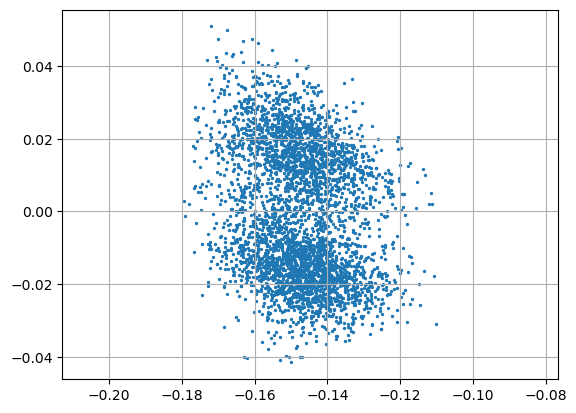

In [2]:
# samplename = "3SXQ-Al-Si-19-5(v1)"
# foldername = r"C:/Users/tsung/Downloads/data/"+samplename+"/"
foldername = r"./data/Tomography/"
pyqum_path = find_file(foldername,7)
# pyqum_path = find_file(foldername)
pyqum = Load_pyqum(pyqum_path)
condition = pyqum.amp_filter(0.11,0.18)
df = pyqum.dataframe[condition]
# df = pyqum.dataframe
plt.grid()
plt.axis('equal')
plt.scatter(df['I'],df['Q'],s = 2)

In [6]:
ground_index, excited_index = 0,1
g = df[(df['XYL']==df['XYL'].unique()[ground_index])]
e = df[(df['XYL']==df['XYL'].unique()[excited_index])]
XYL_ground, XYL_excited = df['XYL'].unique()[ground_index],df['XYL'].unique()[excited_index]
XYL= [XYL_ground, XYL_excited]

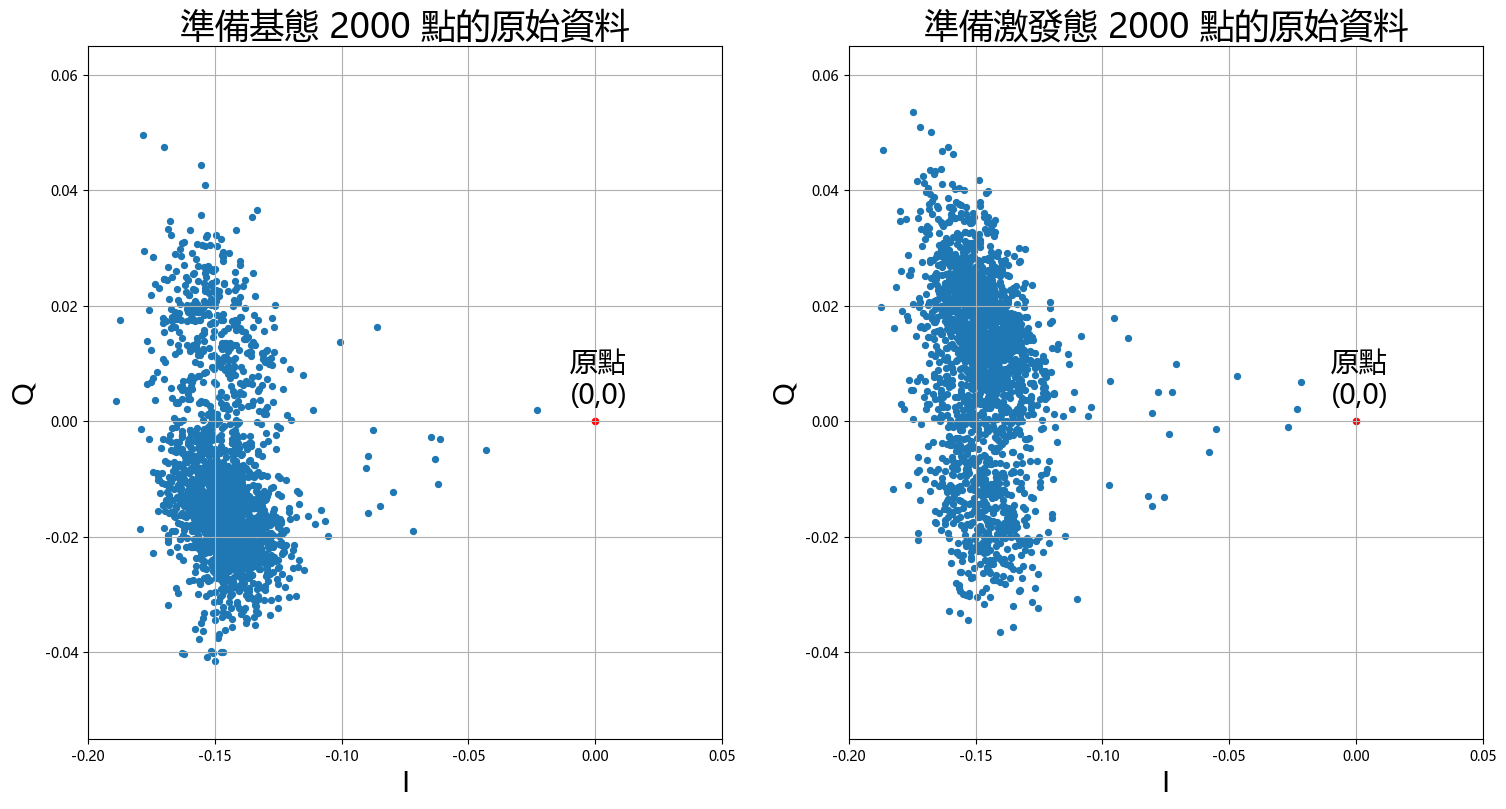

In [7]:
g_raw = pyqum.dataframe[(pyqum.dataframe['XYL']==pyqum.dataframe['XYL'].unique()[0])]
e_raw = pyqum.dataframe[(pyqum.dataframe['XYL']==pyqum.dataframe['XYL'].unique()[1])]
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams["figure.titlesize"] =25
plt.rcParams['axes.titlesize'] =25
plt.rcParams['axes.labelsize'] =20
plt.figure(figsize=(18, 9))
ax1 = plt.subplot(121)
ax1.scatter(g_raw['I'],g_raw['Q'],s = 18)
ax1.scatter(0,0,c='r',s=20)
ax1.text(-0.01,0.003,'原點 \n(0,0)',fontsize=20)
ax1.title.set_text('準備基態 {:d} 點的原始資料'.format(len(g_raw)))
ax1.grid()
# ax1.axis('equal')
ax1.set_xlim(-0.2,0.05)
ax1.set_ylim(-0.055,0.065)
ax1.set_xlabel('I')
ax1.set_ylabel('Q')

ax2 = plt.subplot(122)
ax2.scatter(e_raw['I'],e_raw['Q'],s = 18)
ax2.scatter(0,0,c='r',s=20)
ax2.text(-0.01,0.003,'原點 \n(0,0)',fontsize=20)
ax2.title.set_text('準備激發態 {:d} 點的原始資料'.format(len(e_raw)))
ax2.grid()
# ax2.axis('equal')
ax2.set_xlim(-0.2,0.05)
ax2.set_ylim(-0.055,0.065)
ax2.set_xlabel('I')
ax2.set_ylabel('Q')

# plt.savefig('tomo/prepare_raw.png')

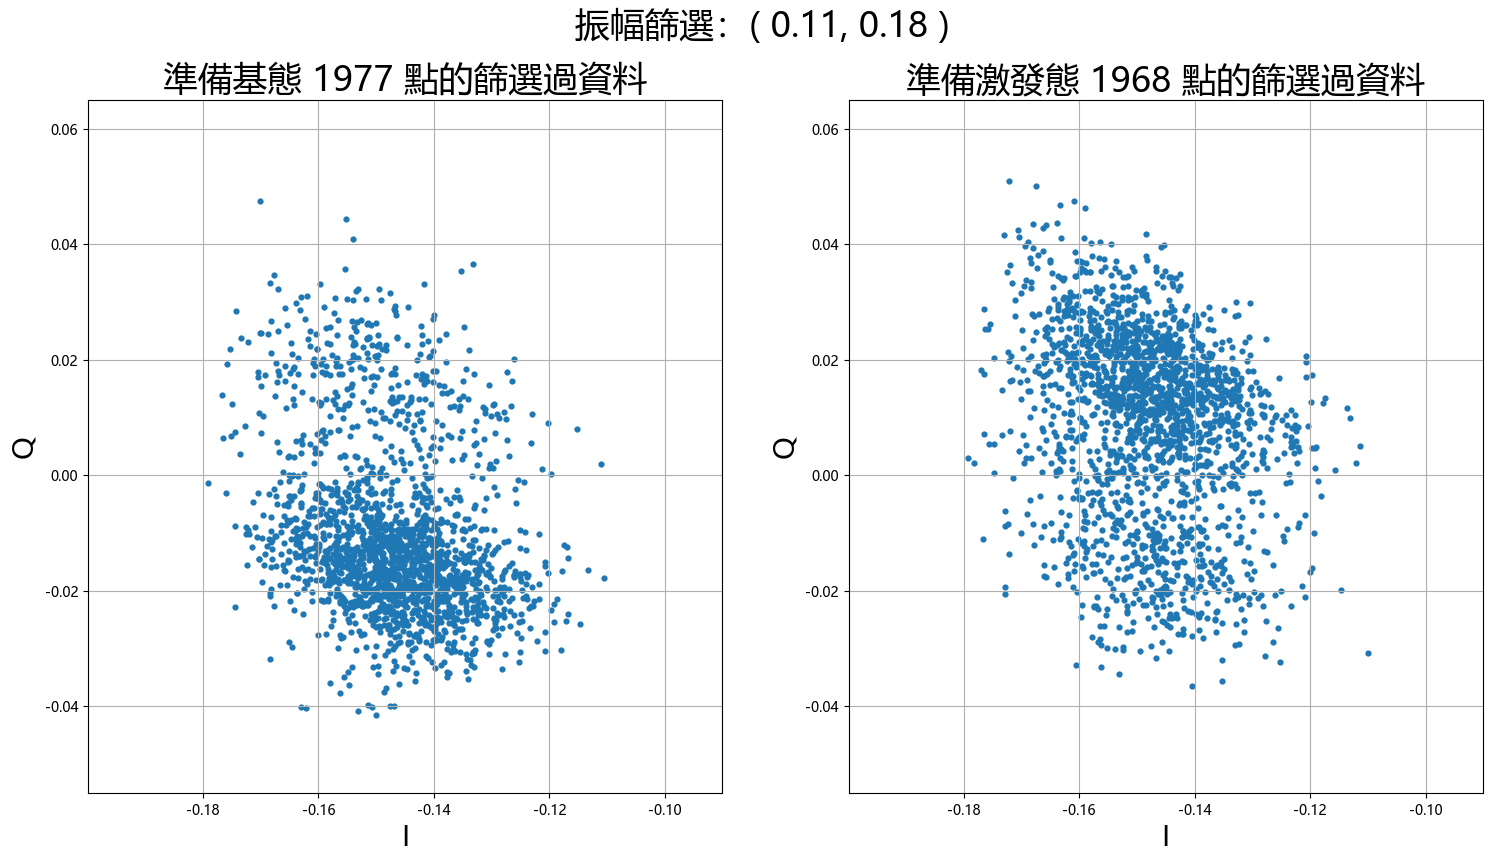

In [8]:
xlim=(-0.18,-0.11)
ylim=(-0.055,0.065)
plt.figure(figsize=(18, 9))
ax1 = plt.subplot(121)
ax1.scatter(g['I'],g['Q'],s = 12)
ax1.title.set_text('準備基態 {:d} 點的篩選過資料'.format(len(g)))
ax1.grid()
ax1.axis('equal')
ax1.set_xlim(xlim)
ax1.set_ylim(ylim)
ax1.set_xlabel('I')
ax1.set_ylabel('Q')

ax2 = plt.subplot(122)
ax2.scatter(e['I'],e['Q'],s = 12)
ax2.title.set_text('準備激發態 {:d} 點的篩選過資料'.format(len(e)))
ax2.grid()
ax2.axis('equal')
ax2.set_xlim(xlim)
ax2.set_ylim(ylim)
ax2.set_xlabel('I')
ax2.set_ylabel('Q')

plt.suptitle('振幅篩選：( 0.11, 0.18 )',fontsize=25)
# plt.savefig('tomo/prepare_filter.png')

S :  0.03164115715601468  ; N :  0.0001610269465502363  ; SNR :  6.217362047905952


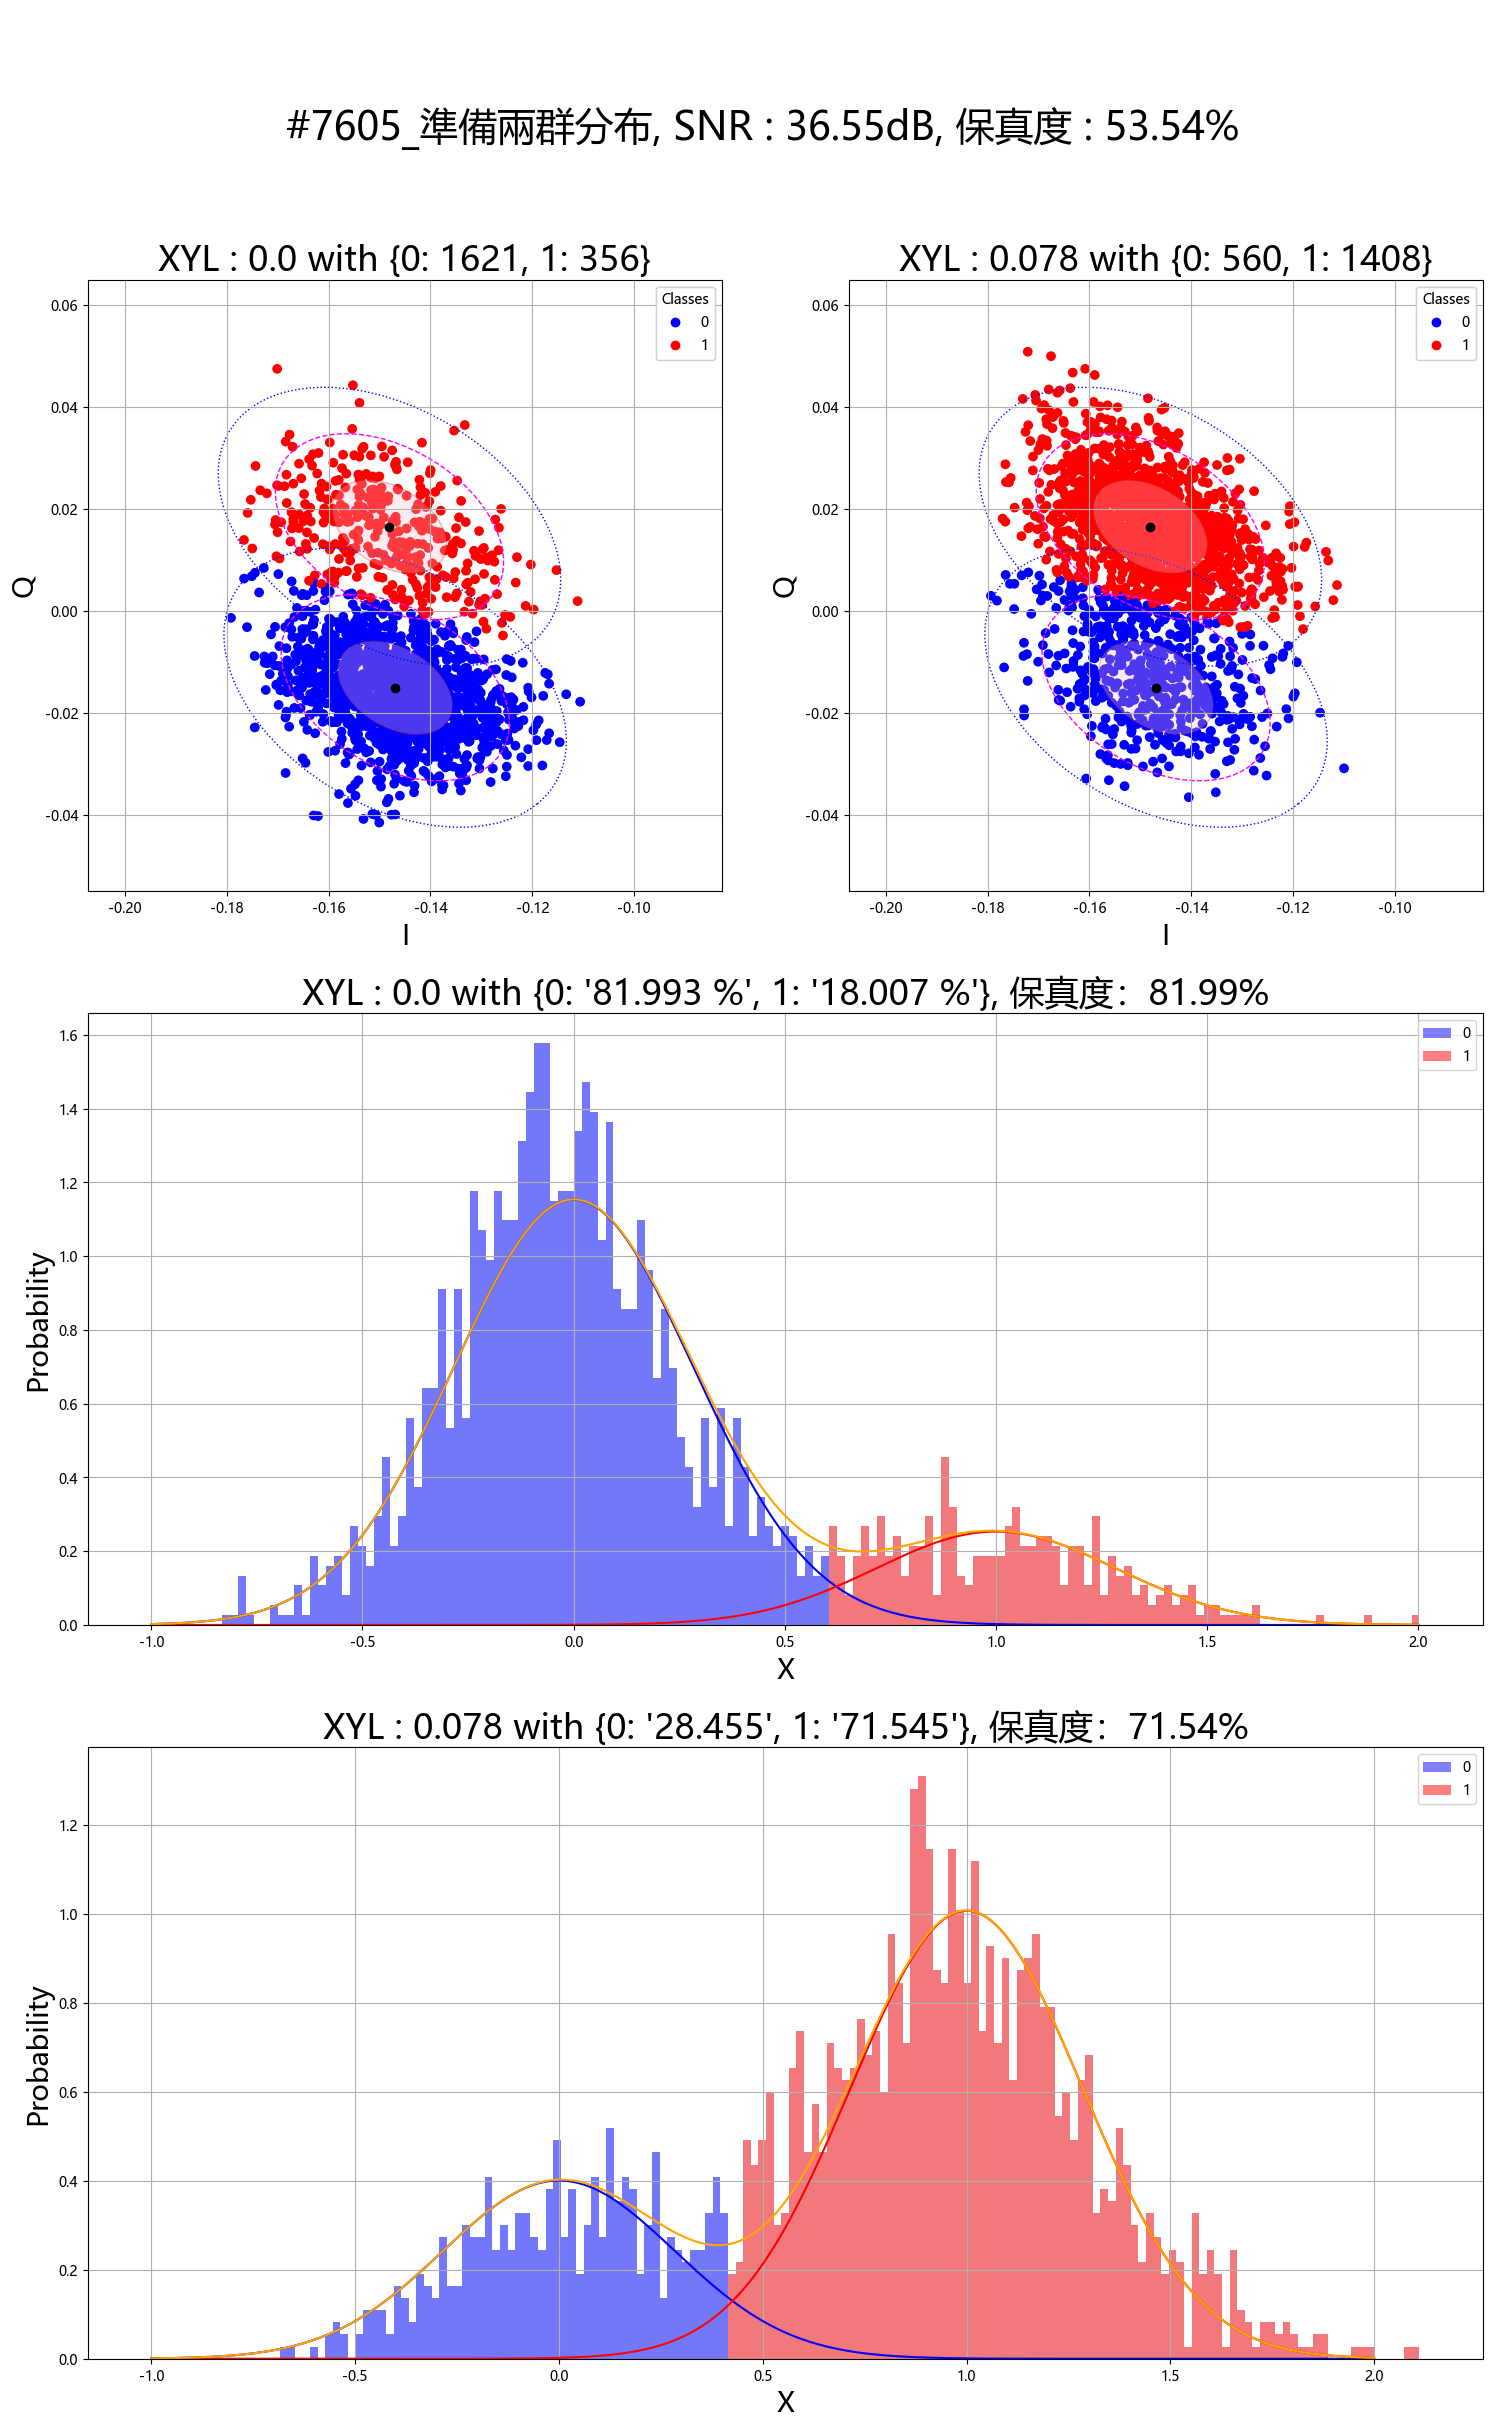

[[80.833, 1.16], [1.643, 16.364]]
[[26.558999999999997, 1.16], [1.533, 70.011]]


<Figure size 640x480 with 0 Axes>

In [9]:
gmm, mark_gmm,data1,label1,data2,label2,S,N,SNR,SNR_dB = gmm_analytic(df,e,g)

title = '準備兩群分布'

cluster_centers,cov,w_a,jobid = gmm.means_,gmm.covariances_,float(pyqum.rjson()['XYF']),pyqum.jobid
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams["figure.titlesize"] =25
plt.rcParams['axes.titlesize'] =25
plt.rcParams['axes.labelsize'] =20
if mark_gmm: 
    label1 = change_label(label1)
    label2 = change_label(label2)
unique1, counts1 = np.unique(label1, return_counts=True)
unique2, counts2 = np.unique(label2, return_counts=True)

plt.figure(figsize=(18, 27))
ax1 = plt.subplot(321)
ax1.axis('equal')
ax1.grid()
scatter1 = ax1.scatter(data1[:, 0],data1[:, 1],c=label1,cmap ='bwr')
legend1 = ax1.legend(*scatter1.legend_elements(), title="Classes")
ax1.add_artist(legend1)
ax1.title.set_text("XYL : "+str(XYL[0])+" with "+str(dict(zip(unique1, counts1))))
ax1.set_xlim(xlim)
ax1.set_ylim(ylim)
ax1.set_xlabel('I')
ax1.set_ylabel('Q')
for i in range(len(cluster_centers)):
    confidence_ellipse_gmm(cluster_centers[i],cov, ax1, n_std=1,facecolor='pink', edgecolor='firebrick',alpha= 0.3)
    confidence_ellipse_gmm(cluster_centers[i],cov, ax1, n_std=2,edgecolor='fuchsia', linestyle='--')
    confidence_ellipse_gmm(cluster_centers[i],cov, ax1, n_std=3,edgecolor='blue', linestyle=':')
    ax1.scatter(cluster_centers[i][0],cluster_centers[i][1],color = "black")
ax2 = plt.subplot(322)
ax2.axis('equal')
ax2.grid()
scatter2 = ax2.scatter(data2[:, 0],data2[:, 1],c=label2,cmap ='bwr')
legend2 = ax2.legend(*scatter2.legend_elements(), title="Classes")
ax2.add_artist(legend2)
ax2.title.set_text("XYL : "+str(XYL[1])+" with "+str(dict(zip(unique2, counts2))))
ax2.set_xlim(xlim)
ax2.set_ylim(ylim)
ax2.set_xlabel('I')
ax2.set_ylabel('Q')
for i in range(len(cluster_centers)):
    confidence_ellipse_gmm(cluster_centers[i],cov, ax2, n_std=1,facecolor='pink', edgecolor='firebrick',alpha= 0.3)
    confidence_ellipse_gmm(cluster_centers[i],cov, ax2, n_std=2,edgecolor='fuchsia', linestyle='--')
    confidence_ellipse_gmm(cluster_centers[i],cov, ax2, n_std=3,edgecolor='blue', linestyle=':')
    ax2.scatter(cluster_centers[i][0],cluster_centers[i][1],color = "black")

p0_1,p1_1 = counts1[0]/(counts1[0]+counts1[1]),counts1[1]/(counts1[0]+counts1[1])
p0_2,p1_2 = counts2[0]/(counts2[0]+counts2[1]),counts2[1]/(counts2[0]+counts2[1])
bins = 150
if mark_gmm:
    refpoint = cluster_centers[1]
    diff = cluster_centers[0]-cluster_centers[1]
else:
    refpoint = cluster_centers[0]
    diff = cluster_centers[1]-cluster_centers[0]
S = scipy.linalg.norm(diff)
rotation_matrix = np.array([[ diff[0]/S,  -diff[1]/S],[ diff[1]/S,  diff[0]/S]])
cov = (rotation_matrix @ gmm.covariances_ @ rotation_matrix.T)
sigma = np.sqrt(cov[0,0])/S
data1_1D = (data1-refpoint)@diff/(S**2)
data2_1D = (data2-refpoint)@diff/(S**2)
x = np.linspace(-1,2,10000)
best_fit_line0 = scipy.stats.norm.pdf(x,0, sigma)
best_fit_line1 = scipy.stats.norm.pdf(x,1, sigma)
cdf0 = scipy.stats.norm.cdf(x,0, sigma)
cdf1 = scipy.stats.norm.cdf(x,1, sigma)
a =pd.DataFrame({'x':x,'y':p0_1*best_fit_line0-p1_1*best_fit_line1,'pdf0':p0_1*best_fit_line0,'pdf1':p1_1*best_fit_line1,'cdf0':p0_1*cdf0,'cdf1':p1_1*cdf1})
b =pd.DataFrame({'x':x,'y':p0_2*best_fit_line0-p1_2*best_fit_line1,'pdf0':p0_2*best_fit_line0,'pdf1':p1_2*best_fit_line1,'cdf0':p0_2*cdf0,'cdf1':p1_2*cdf1})
df_pdf = a[(a['x']<1)&(a['x']>0)]
df_pdf_2 = b[(b['x']<1)&(b['x']>0)]
gg = float(df_pdf.iloc[(df_pdf['y']).abs().argsort()[:1]]['cdf0'])
eg = float(df_pdf.iloc[(df_pdf['y']).abs().argsort()[:1]]['cdf1'])
ge = p0_1-gg
ee = p1_1-eg
gg_2 = float(df_pdf_2.iloc[(df_pdf_2['y']).abs().argsort()[:1]]['cdf0'])
eg_2 = float(df_pdf_2.iloc[(df_pdf_2['y']).abs().argsort()[:1]]['cdf1'])
ge_2 = p0_2-gg_2
ee_2 = p1_2-eg_2
cut = float(df_pdf.iloc[(df_pdf['y']).abs().argsort()[:1]]['x'])
cut2 = float(df_pdf_2.iloc[(df_pdf_2['y']).abs().argsort()[:1]]['x'])

ax3 = plt.subplot(312)
ax3.grid()
n1,locbin1,patch1 =ax3.hist(data1_1D, bins, density=True,alpha=.1)
locbin1 = np.delete(locbin1, 0)
width1 = locbin1[1]-locbin1[0]
ax3.bar(locbin1[locbin1<=cut]-width1/2,n1[locbin1<=cut],width =width1,color='b',alpha =0.5,label=0)
ax3.bar(locbin1[locbin1>cut]-width1/2,n1[locbin1>cut],width =width1,color='r',alpha =0.5,label=1)
ax3.plot(x, p0_1*best_fit_line0,color='b')
ax3.plot(x, p1_1*best_fit_line1,color='r')
ax3.plot(x, p0_1*best_fit_line0+p1_1*best_fit_line1,color = 'orange')
ax3.legend()
ax3.set_xlabel("X")
ax3.set_ylabel("Probability")
ax3.title.set_text("XYL : "+str(XYL[0])+" with "+str(dict(zip(unique1, ['{:.3f} %'.format(100*round(p0_1,5)),'{:.3f} %'.format(100*round(p1_1,5))])))+", 保真度：{:.2f}%".format(100*p0_1))


ax4 = plt.subplot(313)
ax4.grid()
n2,locbin2,patch2 =ax4.hist(data2_1D, bins, density=True,alpha=.1)
locbin2 = np.delete(locbin2, 0)
width2 = locbin2[1]-locbin2[0]
ax4.bar(locbin2[locbin2<=cut2]-width2/2,n2[locbin2<=cut2],width =width2,color='b',alpha =0.5,label=0)
ax4.bar(locbin2[locbin2>cut2]-width2/2,n2[locbin2>cut2],width =width2,color='r',alpha =0.5,label=1)
ax4.plot(x, p0_2*best_fit_line0,color='b')
ax4.plot(x, p1_2*best_fit_line1,color='r')
ax4.plot(x, p0_2*best_fit_line0+p1_2*best_fit_line1,color = 'orange')
ax4.legend()
ax4.set_xlabel("X")
ax4.set_ylabel("Probability")
ax4.title.set_text("XYL : "+str(XYL[1])+" with "+str(dict(zip(unique2, ['{:.3f}'.format(100*round(p0_2,5)),'{:.3f}'.format(100*round(p1_2,5))])))+", 保真度：{:.2f}%".format(100*p1_2))

# T= cal_Tmk(p1_1,w_a)
plt.suptitle("\n\n#{:d}_{:s}, SNR : {:.2f}dB, 保真度 : {:.2f}%".format(jobid,title,SNR_dB,100*(1-p1_1-p0_2)),fontsize=28)
# plt.suptitle("\n\n#{:d}_{:s} SNR : {:.2f}dB, T : {:.2f} mk, 保真度 : {:.2f}%".format(jobid,title,SNR_dB,T,100*(1-p1_1-p0_2)),fontsize=28)

# plt.savefig(r".\tomo\GMM#{:d}_{:s}.png".format(jobid,title))
plt.show()
plt.clf()
percentage_g = [[100*round(gg,5),100*round(ge,5)],[100*round(eg,5),100*round(ee,5)]]
percentage_e = [[100*round(gg_2,5),100*round(ge,5)],[100*round(eg_2,5),100*round(ee_2,5)]]
output = {'# of g':dict(zip(unique1, counts1)),'# of e':dict(zip(unique2, counts2)),'S':S,'N':N,'SNR':SNR,'SNR_dB':SNR_dB,'% of g':percentage_g,'% of e':percentage_e}
print(percentage_g)
print(percentage_e)

In [10]:
model_dir = "./model/"
if not exists(model_dir):
    makedirs(model_dir)
gmm_backup = gmm, mark_gmm,{'S':S,'N':N,'SNR':SNR,'SNR_dB':SNR_dB,'# of g':dict(zip(unique1, counts1)),'# of e':dict(zip(unique2, counts2)),'% of g':percentage_g,'% of e':percentage_e}
modelname = model_dir+'gmm_tomo_model.sav'
pickle.dump(gmm_backup, open(modelname, 'wb'))

In [11]:
model_dir = "./model/"
modelname = model_dir+'gmm_tomo_model.sav'
loaded_model = pickle.load(open(modelname, 'rb'))
gmm, mark_gmm,SNR_dict = loaded_model

In [12]:
foldername = r"./data/Tomography/"
file_dir = listdir(foldername)

In [13]:
key_list = ['File','TOMOR','TOMOL','p0','p1']
df_local_csv = pd.DataFrame({key: [] for key in key_list})
xlim=(-0.18,-0.11)
ylim=(-0.055,0.065)
for file in file_dir:
    if file == 'past'or file=='prepare':
        continue
    pyqum_path = foldername+file
    tomo = Load_pyqum(pyqum_path)
#     plt.scatter(tomo.dataframe['I'],tomo.dataframe['Q'],s = 2)
    for TOMOR in tomo.dataframe['TOMOR'].unique():
        for TOMOL in tomo.dataframe['TOMOL'].unique():
            tmp = tomo.dataframe[(tomo.dataframe['TOMOR']==TOMOR)&(tomo.dataframe['TOMOL']==TOMOL)]
            data = np.stack((tmp['I'], tmp['Q']), axis=1)
            label = gmm.predict(data)
            if mark_gmm: label = change_label(label)
            cluster_centers,cov,jobid = gmm.means_,gmm.covariances_,tomo.jobid
            unique, counts = np.unique(label, return_counts=True)
            print(dict(zip(unique, counts)))
            if 0 not in unique:
                p0 = 0
            else:
                p0= dict(zip(unique, counts))[0]/sum(counts)
            if 1 not in unique:
                p1 = 0
            else:
                p1 = dict(zip(unique, counts))[1]/sum(counts)
            #draw a graph
            plt.figure(figsize=(9, 9))
            plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  
            plt.rcParams['axes.unicode_minus'] = False
            plt.rcParams["figure.titlesize"] =25
            plt.rcParams['axes.titlesize'] =25
            plt.rcParams['axes.labelsize'] =20
            ax1 = plt.subplot(111)
            ax1.axis('equal')
            ax1.grid()
            scatter = ax1.scatter(data[:, 0],data[:, 1],c=label,cmap ='bwr')
            legend = ax1.legend(*scatter.legend_elements(), title="Classes")
            ax1.add_artist(legend)
            ax1.title.set_text("TOMOR : "+str(TOMOR)+", TOMOL : "+str(TOMOL)+" with "+str(dict(zip(unique, counts))))
            ax1.set_xlim(xlim)
            ax1.set_ylim(ylim)
            ax1.set_xlabel('I')
            ax1.set_ylabel('Q')
            for i in range(len(cluster_centers)):
                confidence_ellipse_gmm(cluster_centers[i],cov, ax1, n_std=1,facecolor='pink', edgecolor='firebrick',alpha= 0.3)
                confidence_ellipse_gmm(cluster_centers[i],cov, ax1, n_std=2,edgecolor='fuchsia', linestyle='--')
                confidence_ellipse_gmm(cluster_centers[i],cov, ax1, n_std=3,edgecolor='blue', linestyle=':')
                ax1.scatter(cluster_centers[i][0],cluster_centers[i][1],color = "black")
            plt.suptitle("{:s} #{:d}".format(file,jobid),fontsize=28)
            plt.savefig(r".\tomo\fig_tomo\{:s} TOMOR{:d} TOMOL{:.3f} #{:d}.png".format(file,int(TOMOR),TOMOL,jobid))
            plt.close()
            print({'File':file,'TOMOR':TOMOR,'TOMOL':TOMOL,'p0':p0,'p1':p1})
            del tmp
            df_local_csv.loc[len(df_local_csv)] =[file,TOMOR,TOMOL,p0,p1]
df_local_csv.to_csv('./tomo/6axistomo.csv', index=False)
df_local_csv

./data/Tomography/+I
Comment : 
C1 prepare I TOMO 500+3000
JPA on 12.99/0
ROimRF-9dB
ROoutRF -20
Update: T6=14.816mK, REF#7605,7540,7604,7603,7601,7602,7600

	Data Checked!

Start load data....
R-JSON :
	 ROSTART  :  410000
	 ROdelay  :  280
	 ROL  :  0.06
	 ROW  :  8000
	 ROF  :  6.3483
	 XYL  :  0
	 XYW  :  40
	 XYF  :  4.558
	 XYD  :  0
	 XYR  :  0
	 TOMOR  :  0 90
	 TOMOL  :  0 0.078 0.039 -0.039
	 ROSTART,ROdelay,XYW,REST>ROSTART-ROdelay-2*XYW-REST  :  0
	 REST  :  6
	 ZW  :  500000
	 Z1  :  0.371
	 Z2  :  0
RECORD-SUM :  2000
RECORD_TIME_NS :  3000
Change : 
	 ['TOMOR' 'TOMOL' 'RECORD-SUM']
Change command : 
	 ['0 90' '0 0.078 0.039 -0.039' '1to2000*1999']


     TOMOR      :  0.0   to  90.0  *   2  
     TOMOL      : -0.039 to 0.078  *   4  
{0: 1561, 1: 439}
{'File': '+I', 'TOMOR': 0.0, 'TOMOL': 0.0, 'p0': 0.7805, 'p1': 0.2195}
{0: 599, 1: 1401}
{'File': '+I', 'TOMOR': 0.0, 'TOMOL': 0.078, 'p0': 0.2995, 'p1': 0.7005}
{0: 1087, 1: 913}
{'File': '+I', 'TOMOR': 0.0, 'TOMOL': 0.039

{'File': 'X', 'TOMOR': 0.0, 'TOMOL': 0.078, 'p0': 0.758, 'p1': 0.242}
{0: 978, 1: 1022}
{'File': 'X', 'TOMOR': 0.0, 'TOMOL': 0.039, 'p0': 0.489, 'p1': 0.511}
{0: 1094, 1: 906}
{'File': 'X', 'TOMOR': 0.0, 'TOMOL': -0.039, 'p0': 0.547, 'p1': 0.453}
{0: 629, 1: 1371}
{'File': 'X', 'TOMOR': 90.0, 'TOMOL': 0.0, 'p0': 0.3145, 'p1': 0.6855}
{0: 1579, 1: 421}
{'File': 'X', 'TOMOR': 90.0, 'TOMOL': 0.078, 'p0': 0.7895, 'p1': 0.2105}
{0: 1036, 1: 964}
{'File': 'X', 'TOMOR': 90.0, 'TOMOL': 0.039, 'p0': 0.518, 'p1': 0.482}
{0: 1083, 1: 917}
{'File': 'X', 'TOMOR': 90.0, 'TOMOL': -0.039, 'p0': 0.5415, 'p1': 0.4585}


,File,TOMOR,TOMOL,p0,p1
0,+I,0.0,0.000,0.7805,0.2195
1,+I,0.0,0.078,0.2995,0.7005
2,+I,0.0,0.039,0.5435,0.4565
3,+I,0.0,-0.039,0.5595,0.4405
4,+I,90.0,0.000,0.7955,0.2045
5,+I,90.0,0.078,0.3200,0.6800
6,+I,90.0,0.039,0.5880,0.4120
7,+I,90.0,-0.039,0.5480,0.4520
8,+X_2,0.0,0.000,0.5445,0.4555
9,+X_2,0.0,0.080,0.5050,0.4950


In [14]:
df_tomo = pd.read_csv('./tomo/6axistomo.csv')
df_tomo

,File,TOMOR,TOMOL,p0,p1
0,+I,0.0,0.000,0.7805,0.2195
1,+I,0.0,0.078,0.2995,0.7005
2,+I,0.0,0.039,0.5435,0.4565
3,+I,0.0,-0.039,0.5595,0.4405
4,+I,90.0,0.000,0.7955,0.2045
5,+I,90.0,0.078,0.3200,0.6800
6,+I,90.0,0.039,0.5880,0.4120
7,+I,90.0,-0.039,0.5480,0.4520
8,+X_2,0.0,0.000,0.5445,0.4555
9,+X_2,0.0,0.080,0.5050,0.4950


In [15]:
def rho(SX,SY,SZ):
    I = np.matrix([[1,0],[0,1]])
    SI = 1
    pauli_x = np.matrix([[0,1],[1,0]])
    pauli_y = np.matrix([[0,-1j],[1j,0]])
    pauli_z = np.matrix([[1,0],[0,-1]])
    print("SX = {:.4f} ; SY = {:.4f} ; SZ = {:.4f}".format(SX,SY,SZ))
    print("[SX,SY,SZ] = [{:.4f}, {:.4f}, {:.4f}]".format(SX,SY,SZ))
    print("Dist:",np.linalg.norm([SX,SY,SZ]))
    density_M = SI/2*I+SX/2*pauli_x+SY/2*pauli_y+SZ/2*pauli_z
    rho21 = density_M*density_M
    print("Purity :",np.trace(rho21.real))
    return density_M

In [16]:
total = df_tomo['File'].unique()
total

array(['+I', '+X_2', '+Y_2', '-X_2', '-Y_2', 'X'], dtype=object)

In [17]:
# axis_dict = {'+I':'+Z','+X_2':'-Y','+Y_2':'+X','-X_2':'+Y','-Y_2':'-X', 'X':'-Z'}
axis_dict = {'+I':'+Z','+X_2':'+Y','+Y_2':'-X','-X_2':'-Y','-Y_2':'+X', 'X':'-Z'}

In [20]:
key2_list = ['Axis','File','SX','SY','SZ','Distance','Purity','density_M']
df_bloch_csv = pd.DataFrame({key: [] for key in key2_list},dtype=object)

+I
[ 0. 90.]
[ 0.     0.078  0.039 -0.039]
[0.176, -0.09600000000000003]
[0.119, -0.08699999999999997]
[0.5760000000000001, 0.38050000000000006]
SX = 0.0400 ; SY = 0.0160 ; SZ = 0.4783
[SX,SY,SZ] = [0.0400, 0.0160, 0.4783]
Dist: 0.4801864872109586
Purity : 0.6152895312499999


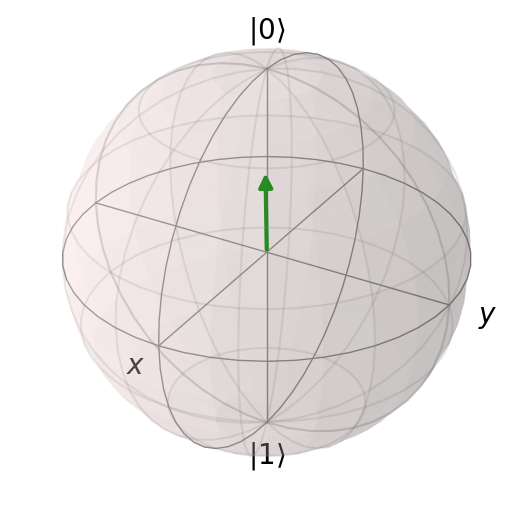

+X_2
[ 0. 90.]
[ 0.    0.08  0.04 -0.04]
[0.09099999999999997, -0.121]
[0.5169999999999999, 0.43]
[0.08999999999999991, -0.0009999999999999454]
SX = -0.0150 ; SY = 0.4735 ; SZ = 0.0445
[SX,SY,SZ] = [-0.0150, 0.4735, 0.0445]
Dist: 0.47582297128238765
Purity : 0.6132037499999999


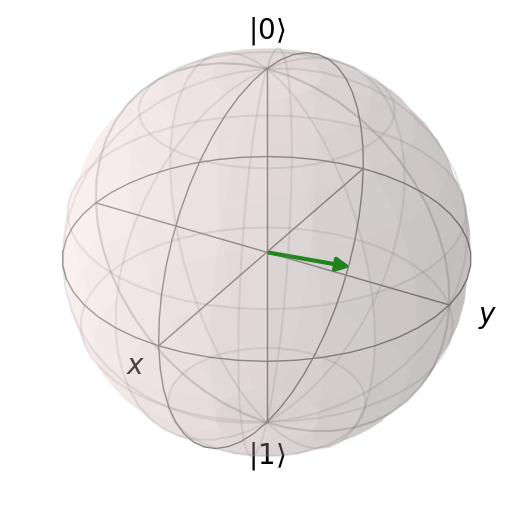

+Y_2
[ 0. 90.]
[ 0.    0.08  0.04 -0.04]
[-0.422, -0.5880000000000001]
[-0.014999999999999958, -0.0009999999999999454]
[0.07450000000000001, 0.00649999999999995]
SX = -0.5050 ; SY = -0.0080 ; SZ = 0.0405
[SX,SY,SZ] = [-0.5050, -0.0080, 0.0405]
Dist: 0.5066845665697742
Purity : 0.628364625


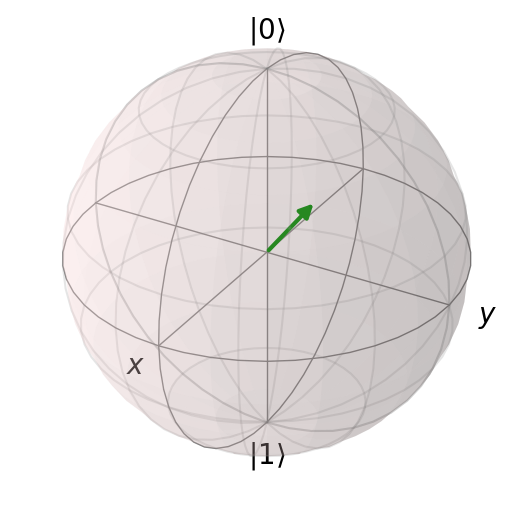

-X_2
[ 0. 90.]
[ 0.    0.08  0.04 -0.04]
[0.23399999999999999, -0.13999999999999996]
[-0.422, -0.575]
[0.07200000000000001, -0.07899999999999996]
SX = 0.0470 ; SY = -0.4985 ; SZ = -0.0035
[SX,SY,SZ] = [0.0470, -0.4985, -0.0035]
Dist: 0.5007229773038181
Purity : 0.6253617500000002


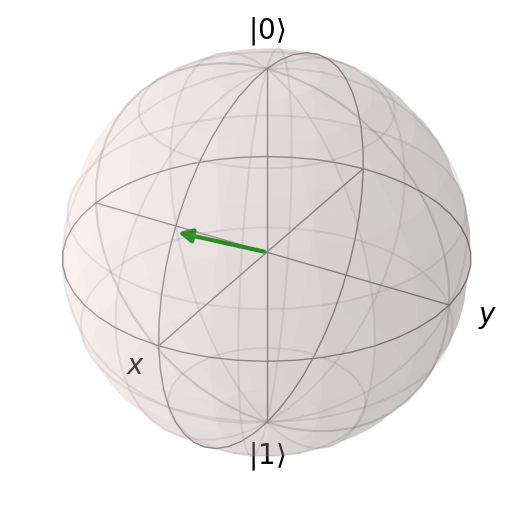

-Y_2
[ 0. 90.]
[ 0.    0.08  0.04 -0.04]
[0.5820000000000001, 0.457]
[0.06899999999999995, -0.16700000000000004]
[0.07900000000000007, -0.06000000000000005]
SX = 0.5195 ; SY = -0.0490 ; SZ = 0.0095
[SX,SY,SZ] = [0.5195, -0.0490, 0.0095]
Dist: 0.5218922302544847
Purity : 0.6361857500000001


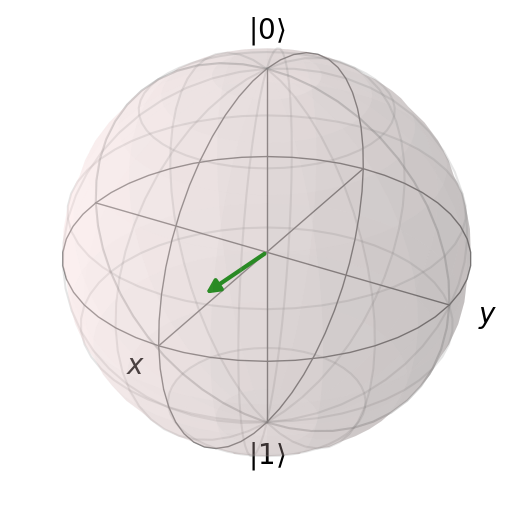

X
[ 0. 90.]
[ 0.     0.078  0.039 -0.039]
[0.03600000000000003, -0.08299999999999996]
[0.09400000000000003, 0.02200000000000002]
[-0.39250000000000007, -0.5474999999999999]
SX = -0.0235 ; SY = 0.0580 ; SZ = -0.4700
[SX,SY,SZ] = [-0.0235, 0.0580, -0.4700]
Dist: 0.47414791995747485
Purity : 0.612408125


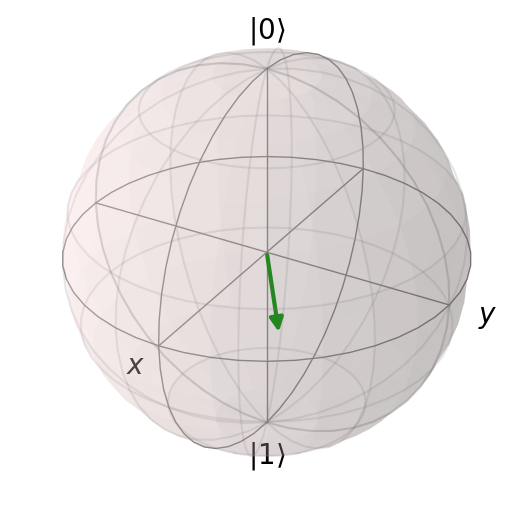

In [21]:
for pick in range(len(total)): 
    print(total[pick])
    gate = (df_tomo['File']== total[pick])
    print(df_tomo[gate]['TOMOR'].unique())
    print(df_tomo[gate]['TOMOL'].unique())
    df_pick = df_tomo[gate]
    X,Y = df_pick['TOMOR'].unique()[0],df_pick['TOMOR'].unique()[1]
    x,y = (df_pick['TOMOR']==X),(df_pick['TOMOR']==Y)
    r0,r,r2,r_2 = df_pick['TOMOL'].unique()
    pi0,pi,pi2,pi_2 = (df_pick['TOMOL']==r0),(df_pick['TOMOL']==r),(df_pick['TOMOL']==r2),(df_pick['TOMOL']==r_2)
    meaX,mea_X = (pi2&y),(pi_2&y)
    meaY,mea_Y = (pi_2&x),(pi2&x)
    meaZ,mea_Z = ((pi0&x)|(pi0&y)),((pi&x)|(pi&y))
    sx = [df_pick[meaX]['p0'].to_numpy().mean()-df_pick[meaX]['p1'].to_numpy().mean(),df_pick[mea_X]['p1'].to_numpy().mean()-df_pick[mea_X]['p0'].to_numpy().mean()]
    sy = [df_pick[meaY]['p0'].to_numpy().mean()-df_pick[meaY]['p1'].to_numpy().mean(),df_pick[mea_Y]['p1'].to_numpy().mean()-df_pick[mea_Y]['p0'].to_numpy().mean()]
    sz = [df_pick[meaZ]['p0'].to_numpy().mean()-df_pick[meaZ]['p1'].to_numpy().mean(),df_pick[mea_Z]['p1'].to_numpy().mean()-df_pick[mea_Z]['p0'].to_numpy().mean()]
    print(sx)
    print(sy)
    print(sz)
    SX,SY,SZ = np.average(sx),np.average(sy),np.average(sz)
    density_M =rho(SX,SY,SZ)
    b= Bloch()
    b.add_vectors([SX,SY,SZ])
    b.show()
    axis = axis_dict[total[pick]]
    b.save('tomo/'+axis+' axis.png')
    df_bloch_csv.loc[len(df_bloch_csv)] =[axis,total[pick],SX,SY,SZ,np.linalg.norm([SX,SY,SZ]),np.trace((density_M*density_M).real),density_M]

In [22]:
df_bloch_csv

,Axis,File,SX,SY,SZ,Distance,Purity,density_M
0,+Z,+I,0.0400,0.0160,0.47825,0.480186,0.615290,"[[[[[0.739125+0.j 0.02 -0.008j]]]], [[[[..."
1,+Y,+X_2,-0.0150,0.4735,0.04450,0.475823,0.613204,"[[[[[ 0.52225+0.j -0.0075 -0.23675j]]]], ..."
2,-X,+Y_2,-0.5050,-0.0080,0.04050,0.506685,0.628365,"[[[[[ 0.52025+0.j -0.2525 +0.004j]]]], [[[[..."
3,-Y,-X_2,0.0470,-0.4985,-0.00350,0.500723,0.625362,"[[[[[0.49825+0.j 0.0235 +0.24925j]]]], [[..."
4,+X,-Y_2,0.5195,-0.0490,0.00950,0.521892,0.636186,"[[[[[0.50475+0.j 0.25975+0.0245j]]]], [[[[..."
5,-Z,X,-0.0235,0.0580,-0.47000,0.474148,0.612408,"[[[[[ 0.265 +0.j -0.01175-0.029j]]]], [[[[..."


In [23]:
df_bloch_csv.to_csv('./tomo/6axistomo_bloch.csv', index=False)

In [24]:
df_bloch = pd.read_csv('./tomo/6axistomo_bloch.csv')
df_bloch

,Axis,File,SX,SY,SZ,Distance,Purity,density_M
0,+Z,+I,0.0400,0.0160,0.47825,0.480186,0.615290,[[0.739125+0.j 0.02 -0.008j]\n [0.02 ...
1,+Y,+X_2,-0.0150,0.4735,0.04450,0.475823,0.613204,[[ 0.52225+0.j -0.0075 -0.23675j]\n [-0.0...
2,-X,+Y_2,-0.5050,-0.0080,0.04050,0.506685,0.628365,[[ 0.52025+0.j -0.2525 +0.004j]\n [-0.2525 ...
3,-Y,-X_2,0.0470,-0.4985,-0.00350,0.500723,0.625362,[[0.49825+0.j 0.0235 +0.24925j]\n [0.0235...
4,+X,-Y_2,0.5195,-0.0490,0.00950,0.521892,0.636186,[[0.50475+0.j 0.25975+0.0245j]\n [0.25975-...
5,-Z,X,-0.0235,0.0580,-0.47000,0.474148,0.612408,[[ 0.265 +0.j -0.01175-0.029j]\n [-0.01175...


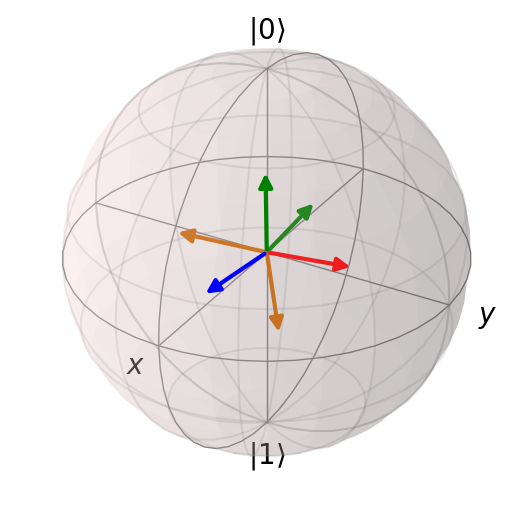

In [25]:
Axis = ['+Z', '-Y', '+X','+Y', '-X', '-Z']
b= Bloch()
for axis in Axis:
    SX = df_bloch[df_bloch['Axis'] == axis]['SX'].to_numpy()[0]
    SY = df_bloch[df_bloch['Axis'] == axis]['SY'].to_numpy()[0]
    SZ = df_bloch[df_bloch['Axis'] == axis]['SZ'].to_numpy()[0]
    b.add_vectors([SX,SY,SZ])
b.show()
b.save('tomo/6axis bloch sphere.png')

In [26]:
df_bloch['Axis'].unique()

array(['+Z', '+Y', '-X', '-Y', '+X', '-Z'], dtype=object)